# 3D Single-shot Object Detection Method (With 3D Transformations)
---------------------------------------
#### By: Juan C. Peña and Eberto Benjumea

In [1]:
%%capture
!pip install deeptrack

In [2]:
%%capture
import os
import cv2
import scipy
import random
import numpy as np
import deeptrack as dt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial.transform import Rotation as R

In [3]:
%%capture
from google.colab import drive
drive.mount('/content/drive')

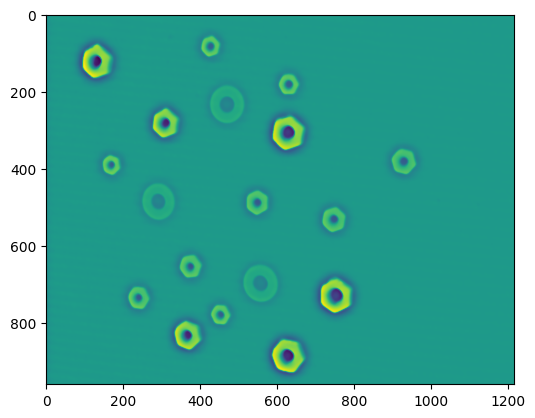

In [4]:
train_data = scipy.io.loadmat('/content/drive/MyDrive/Investigacion/Data/MATLAB/3D/reconstruction12.mat')
Spx, Spy, Spz = train_data['XcM'], train_data['YcM'], train_data['Spz']
plt.imshow(Spz)

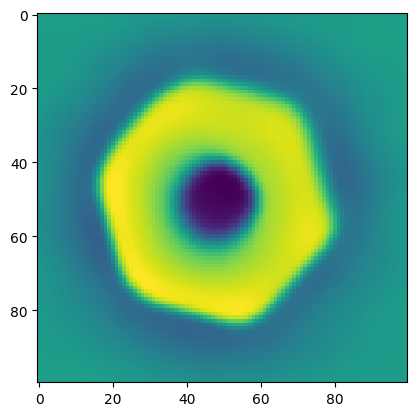

In [5]:
x, y, crop_size = (880, 332, 100)
crop = Spz[y : y+crop_size, x : x+crop_size]
plt.imshow(crop)

In [6]:
# Copia de los datos originales para visualización posterior
previous_crop = np.copy(crop)

# Preprocesando el crop
crop = np.nan_to_num(crop)
crop = (crop - np.quantile(crop, 0.01)) / (np.quantile(crop, 0.99) - np.quantile(crop, 0.01))

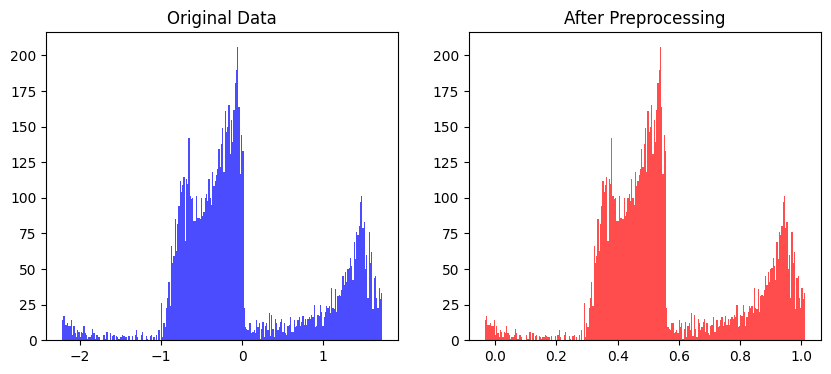

In [7]:
# Visualización
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Histograma de los datos originales
ax[0].hist(previous_crop.ravel(), bins=256, color='blue', alpha=0.7)
ax[0].set_title("Original Data")

# Histograma después de la normalización
ax[1].hist(crop.ravel(), bins=256, color='red', alpha=0.7)
ax[1].set_title("After Preprocessing")

plt.show()

## ETAPA CRUCIAL
----------------

### Transformaciones recomendadas (Ejemplo tuercas):
- Rotación en z(az) = [-5, 5] pero creo que se puede aumentar como máximo hasta [-30, 30]
- Rotaciones en X (ax) e Y (ay) = [-5, 5] pero creo que se puede aumentar como máximo hasta [-10, 10]
- Traslaciones en X (tx) e Y (ty) = [-crop_size$*$0.05, crop_size$*$0.05]
- Traslaciones en Z (tz) = [0, 0] considero que es mejor dejar este parámetro sin transformar.

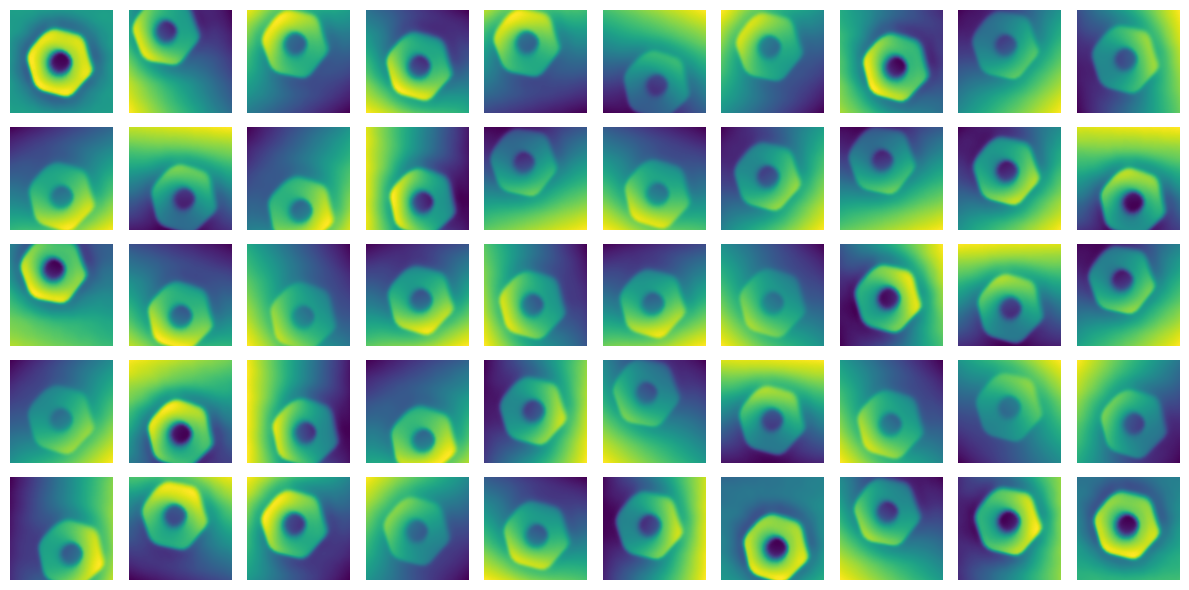

In [8]:
# Crear una matriz 4D para las coordenadas X, Y, Z y una matriz de unos del mismo tamaño
coordinates = np.stack([Spx, Spy, Spz, np.ones_like(Spz)])

# Definir los rangos de transformación
transformation_ranges = {'ax': [-5, 5], 'ay': [-5, 5], 'az': [-5, 5],
                         'tx': [-crop_size*0.05, crop_size*0.05], 'ty': [-crop_size*0.05, crop_size*0.05], 'tz': [0, 0]}


# Definir la cantidad de imágenes a generar
num_images = 50

# Crear una lista para almacenar los crops transformados
transformed_crops = []

# Agregar el crop original a la lista de crops transformados
original_crop = crop
transformed_crops.append(original_crop)

# Iterar sobre la cantidad de imágenes a generar (restando 1 para el recorte original)
for _ in range(num_images - 1):
    # Generar las transformaciones aleatorias dentro de los rangos especificados
    ax = np.random.uniform(*transformation_ranges['ax'])
    ay = np.random.uniform(*transformation_ranges['ay'])
    az = np.random.uniform(*transformation_ranges['az'])
    tx = np.random.uniform(*transformation_ranges['tx'])
    ty = np.random.uniform(*transformation_ranges['ty'])
    tz = np.random.uniform(*transformation_ranges['tz'])

    # Crear la matriz de rotación utilizando scipy
    r = R.from_euler('xyz', [ax, ay, az], degrees=True)
    Rrec = r.as_matrix()

    # Crear la matriz de transformación
    Mext_rec = np.eye(4)
    Mext_rec[:3, :3] = Rrec

    # Transformar los puntos utilizando la matriz de transformación
    transformed_coordinates = Mext_rec @ coordinates.reshape(4, -1)

    # Remodelar los puntos transformados de vuelta a la forma original
    transformed_coordinates = transformed_coordinates.reshape(4, Spz.shape[0], Spz.shape[1])

    # Crear la nueva imagen 2.5D con los valores de Z transformados
    new_image_2_5D = transformed_coordinates[2, :, :]

    # Realizar la traslación en X e Y en la imagen 2.5D
    translated_image_2_5D = np.roll(new_image_2_5D, (int(tx), int(ty)), axis=(1, 0))

    # Realizar la rotación en Z y la traslación en Z en la imagen 2.5D
    rows, cols = translated_image_2_5D.shape
    M = cv2.getRotationMatrix2D((cols/2, rows/2), az, 1)
    dst = cv2.warpAffine(translated_image_2_5D, M, (cols, rows))
    transformed_image = dst + tz

    # Obtener el crop de la imagen transformada
    transformed_crop = transformed_image[y : y+crop_size, x : x+crop_size]

    # Agregar el crop transformado a la lista de crops transformados
    transformed_crops.append(transformed_crop)

num_cols = 10
num_images = len(transformed_crops)
num_rows = int(np.ceil(num_images / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

for i, ax in enumerate(axes.flatten()):
    if i < num_images:
        ax.imshow(transformed_crops[i])
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [9]:
# Normalizando los crops transformados
transformed_crops = [(crop - np.quantile(crop, 0.01)) / (np.quantile(crop, 0.99) - np.quantile(crop, 0.01)) for crop in transformed_crops]

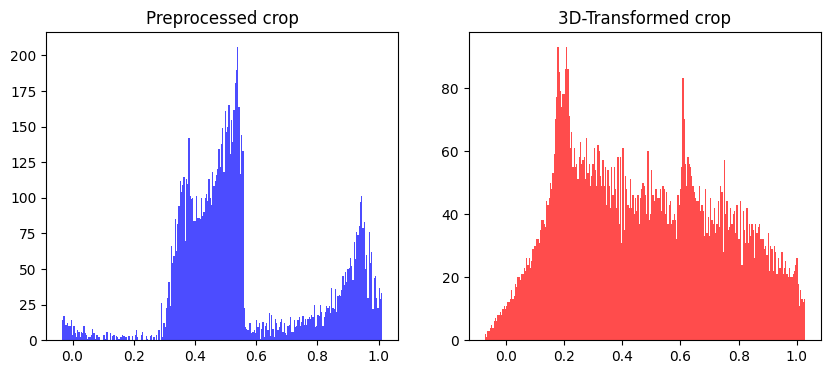

In [10]:
# Visualización
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Histograma de los datos originales
ax[0].hist(crop.ravel(), bins=256, color='blue', alpha=0.7)
ax[0].set_title("Preprocessed crop")

# Histograma después de la normalización
ax[1].hist(transformed_crops[2].ravel(), bins=256, color='red', alpha=0.7)
ax[1].set_title("3D-Transformed crop")

plt.show()

## ETAPA CRUCIAL
----------------

### Tamaño de las imágenes de entrenamiento
Para este ejemplo en específico funciona bien con 20, pero es necesario revisar si sigue funcionando con un mayor tamaño o si tenemos que cambiar la arquitectura de la red.

In [11]:
wide = 20 # size of the training template
downsample = crop_size // wide

## ETAPA CRUCIAL
----------------

### Transformaciones a realizar
- No estoy seguro si volver a hacer traslaciones sea lo correcto, ya que se hace muy bien en la etapa de transformaciones 3D.
- Sería bueno revisar también si es bueno o no aplicar el ruido Gaussiano, y en qué medida.

In [12]:
transformations = (
    dt.Affine(translate=lambda:np.random.uniform(-1.5, 1.5, 2), rotate=lambda: np.random.rand()*np.pi*2),
    dt.AveragePooling(ksize=(downsample, downsample, 1)),
    dt.Add(lambda: np.random.randn() * 0.1),
    dt.Gaussian(sigma=lambda:np.random.uniform(0, 0.01)),
    dt.Multiply(lambda: np.random.uniform(0.6, 1.2))
)

In [13]:
pipeline = None
for transformation in transformations:
  if pipeline is None:
    pipeline = transformation
  else:
    pipeline = pipeline >> transformation

In [14]:
training_images = [np.expand_dims(image, axis=-1) for image in transformed_crops]
train_set = dt.Value(lambda: np.array(random.choice(training_images))) >> pipeline

<Axes: >

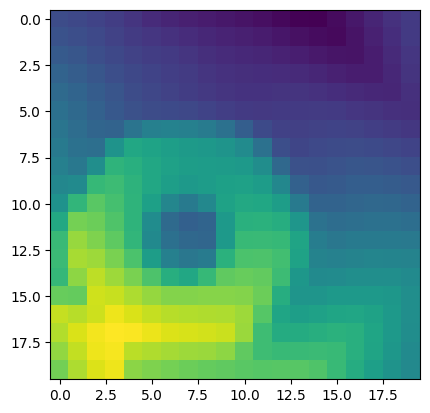

In [15]:
train_set.plot()

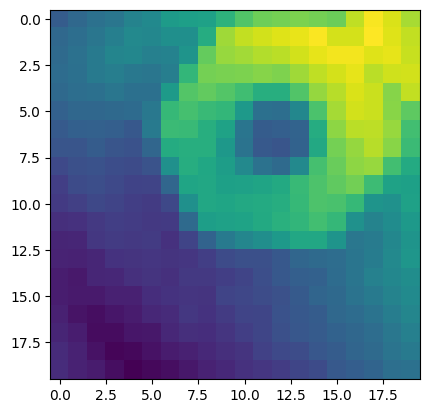

In [16]:
transformed_image = train_set.update()()
plt.imshow(transformed_image)

In [17]:
weights_path = '/content/drive/MyDrive/Investigacion/Model/checkpoints/3Ddebugging'
TRAIN_MODE = True

In [18]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

model = dt.models.LodeSTAR(input_shape=(None, None, 1))

callbacks = [ModelCheckpoint(filepath=weights_path,
                             save_weights_only=True,
                             monitor='total_loss',
                             mode='min',
                             save_best_only=True),
             EarlyStopping(monitor="total_loss",
                           patience=15,
                           verbose=1,
                           mode="auto",
                           restore_best_weights=True),
             LearningRateScheduler(lambda epoch, lr: lr if epoch < 10 else lr * np.exp(-0.1))]

In [19]:
if TRAIN_MODE:
  history = model.fit(train_set,
                      epochs=40,
                      batch_size=8,
                      callbacks=callbacks)

Generating 164 / 160 samples before starting training
Epoch 1/40
164/164 [==============================] - 19s 18ms/step - total_loss: 2.0304 - consistency_loss: 0.6455 - lr: 0.0010
Epoch 2/40
164/164 [==============================] - 8s 48ms/step - total_loss: 1.4510 - consistency_loss: 0.3532 - lr: 0.0010                         
Epoch 3/40
164/164 [==============================] - 6s 39ms/step - total_loss: 0.6385 - consistency_loss: 0.1163 - lr: 0.0010                          
Epoch 4/40
164/164 [==============================] - 8s 50ms/step - total_loss: 0.1215 - consistency_loss: 0.0184 - lr: 0.0010                         
Epoch 5/40
164/164 [==============================] - 7s 40ms/step - total_loss: 0.0883 - consistency_loss: 0.0121 - lr: 0.0010                         
Epoch 6/40
164/164 [==============================] - 9s 52ms/step - total_loss: 0.0762 - consistency_loss: 0.0100 - lr: 0.0010                         
Epoch 7/40
164/164 [==============================]

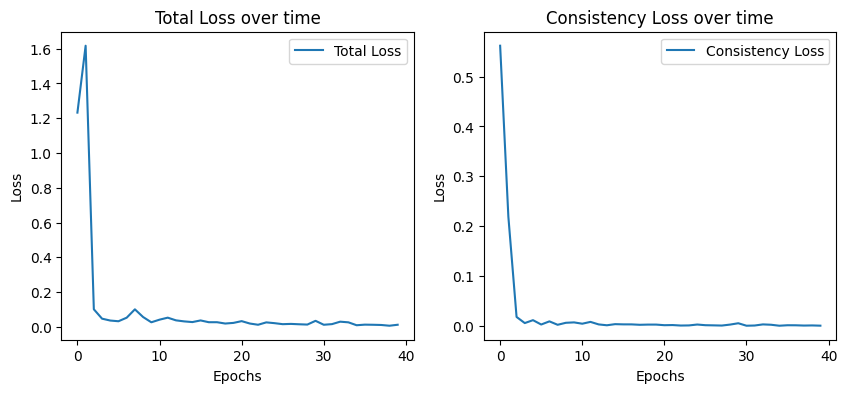

In [20]:
if TRAIN_MODE:
  fig, ax = plt.subplots(1, 2, figsize=(10, 4))

  # Plot total_loss
  ax[0].plot(history.history['total_loss'], label='Total Loss')
  ax[0].set_title('Total Loss over time')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].legend()

  # Plot consistency_loss
  ax[1].plot(history.history['consistency_loss'], label='Consistency Loss')
  ax[1].set_title('Consistency Loss over time')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  ax[1].legend()

  plt.show()

In [21]:
%%capture
model.load_weights(weights_path)

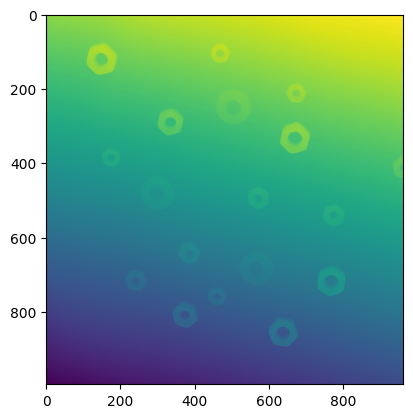

In [22]:
test_data = scipy.io.loadmat(f'/content/drive/MyDrive/Investigacion/Data/MATLAB/Reconstructions/with_surface_base/rec_r3d_smooth_pose_16.mat')
test_image = test_data['ZcM_r']
plt.imshow(test_image)

In [23]:
# Copia de los datos originales para visualización posterior
previous_test_image = np.copy(test_image)

# Preprocesando la imagen de prueba
test_image = np.nan_to_num(test_image)
test_image = (test_image - np.quantile(test_image, 0.01)) / (np.quantile(test_image, 0.99) - np.quantile(test_image, 0.01))

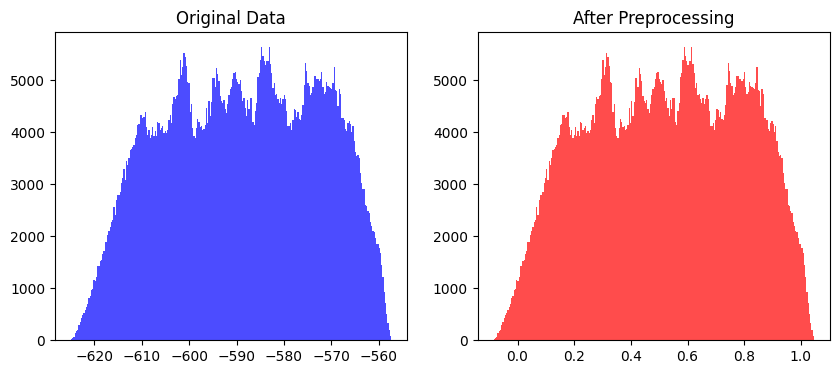

In [24]:
# Visualización
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Histograma de los datos originales
ax[0].hist(previous_test_image.ravel(), bins=256, color='blue', alpha=0.7)
ax[0].set_title("Original Data")

# Histograma después de la normalización
ax[1].hist(test_image.ravel(), bins=256, color='red', alpha=0.7)
ax[1].set_title("After Preprocessing")

plt.show()

## ETAPA CRUCIAL
----------------

### Escalas de las imágenes
- Las escalas utilizadas originalmente eran [1,2,4], representando la imagen en tamaño original, la mitad y la cuarta parte.
- Estas escalas se pueden ajustar para generar más o menos detecciones.
- Para este ejemplo, funciona bien [1, 1.25, 1.75]

In [25]:
scales = [1, 1.5, 1.75]
x_shape = test_image.shape[0]
y_shape = test_image.shape[1]
scaled_images = [cv2.resize(test_image, (int(y_shape//scale), int(x_shape//scale))) for scale in scales]

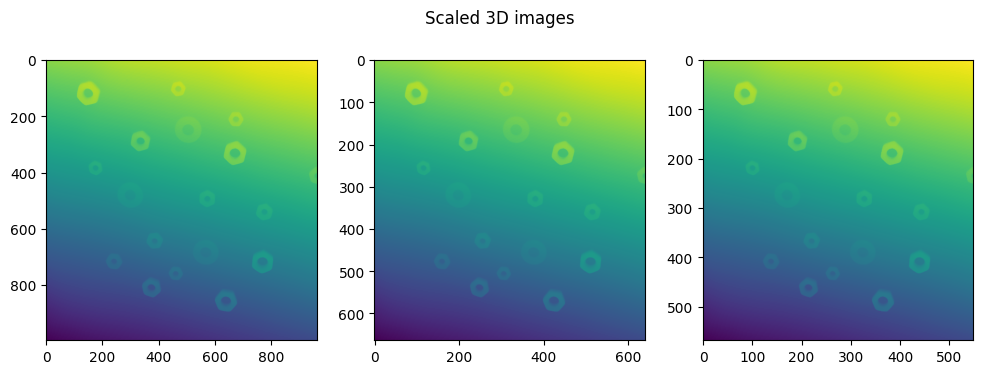

In [26]:
fig, ax = plt.subplots(1, len(scaled_images), figsize=(10,4))
fig.tight_layout()
fig.suptitle('Scaled 3D images', y=1)
for index in range(len(scaled_images)):
  ax[index].imshow(scaled_images[index])

## ETAPA CRUCIAL
----------------

### Parámetros de detección
- De estos valores depende mayormente la calidad de las detecciones, así que es necesario obtener unos valores óptimos.
- Para este ejemplo, funciona bien:
   - cutoff = 0.985
   - alpha = 1 - cutoff
   - mode = "quantile"

In [52]:
# Detection settings
cutoff = 0.9
alpha = 1 - cutoff
mode = "quantile"
all_detections = []

for index in range(len(scaled_images)):
  # Aqui se hace el expand_dims(axis=-1) del preprocessing
  test_set = scaled_images[index][np.newaxis, :, :, np.newaxis]
  test_set = test_set[:, ::downsample, ::downsample, :]
  # Esta es la mejor configuracion? Revisar sobre todo 'beta'. [REVISAR PAPER]
  detections = model.predict_and_detect(test_set, alpha=alpha, beta=1-alpha, cutoff=cutoff, mode=mode)[0]
  detections[:, 0] = detections[:, 0] * downsample
  detections[:, 1] = detections[:, 1] * downsample
  all_detections.append(detections)

1/1 [==============================] - 0s 37ms/step


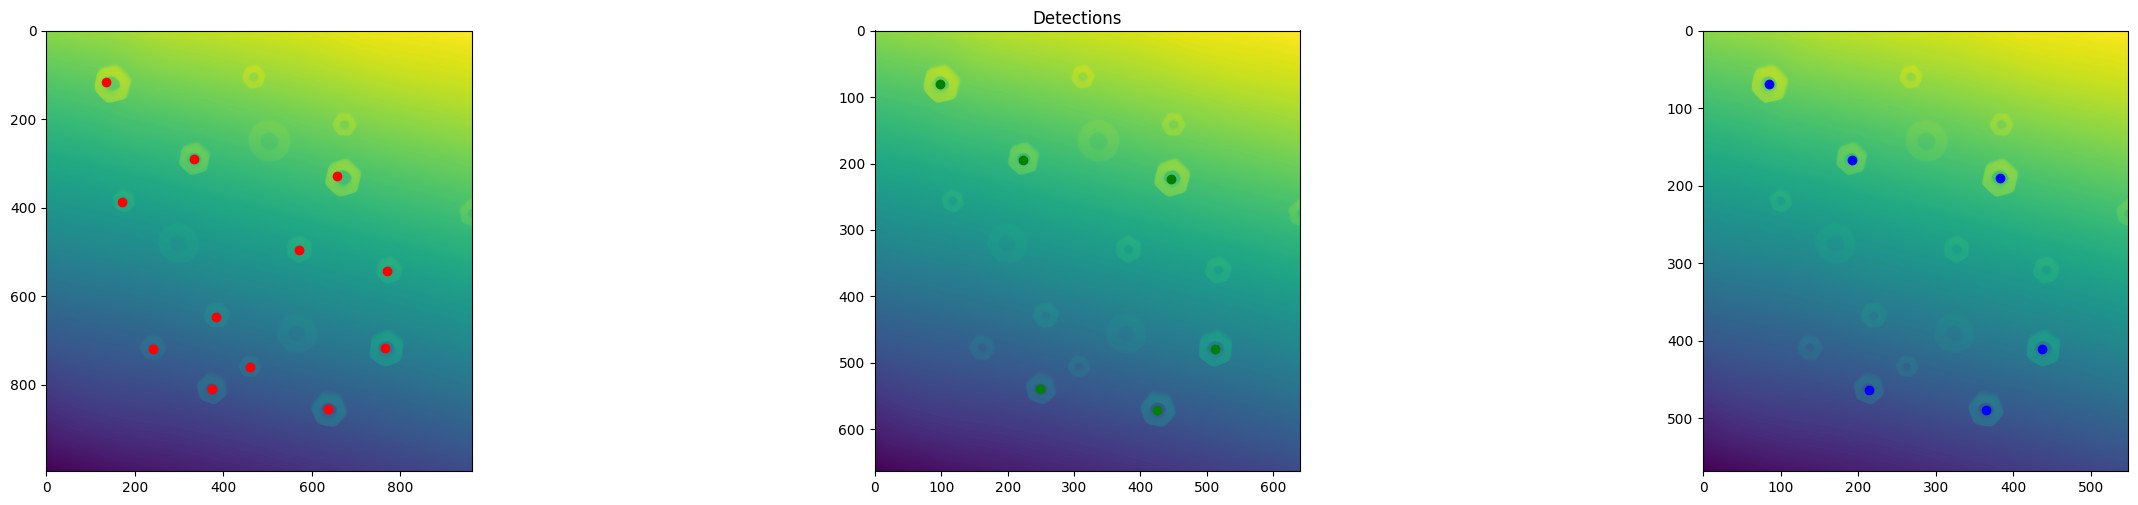

In [53]:
fig, ax = plt.subplots(1, len(scaled_images), figsize=(25, 5))
fig.tight_layout()
fig.suptitle('Detections', y=1)
colors = 'rgb'

for index in range(len(scaled_images)):
  ax[index].imshow(scaled_images[index])
  ax[index].scatter(all_detections[index][:, 1], all_detections[index][:, 0], color=colors[index])

In [54]:
final_image = scaled_images[0]
# El tamaño del bounding box depende del tamaño del objeto a detectar
original_box_size = crop_size

all_bboxes = []

# dimensiones de la imagen original
original_height, original_width = final_image.shape[:2]

for index in range(len(all_detections)):
    # dimensiones de la imagen actual
    current_height, current_width = scaled_images[index].shape[:2]

    # calcula el box_size proporcional a la escala de la imagen
    box_size = original_box_size * (current_height / original_height)
    half_size = box_size / 2.0

    bboxes = np.zeros((len(all_detections[index]), 4))  # shape: (num_coords, 4)

    for i, point in enumerate(all_detections[index]):  # Iterar sobre all_detections[index]
        bboxes[i, 0] = point[0] - half_size  # inicio y
        bboxes[i, 1] = point[1] - half_size  # inicio x
        bboxes[i, 2] = point[0] + half_size  # fin y
        bboxes[i, 3] = point[1] + half_size  # fin x

    all_bboxes.append(bboxes)

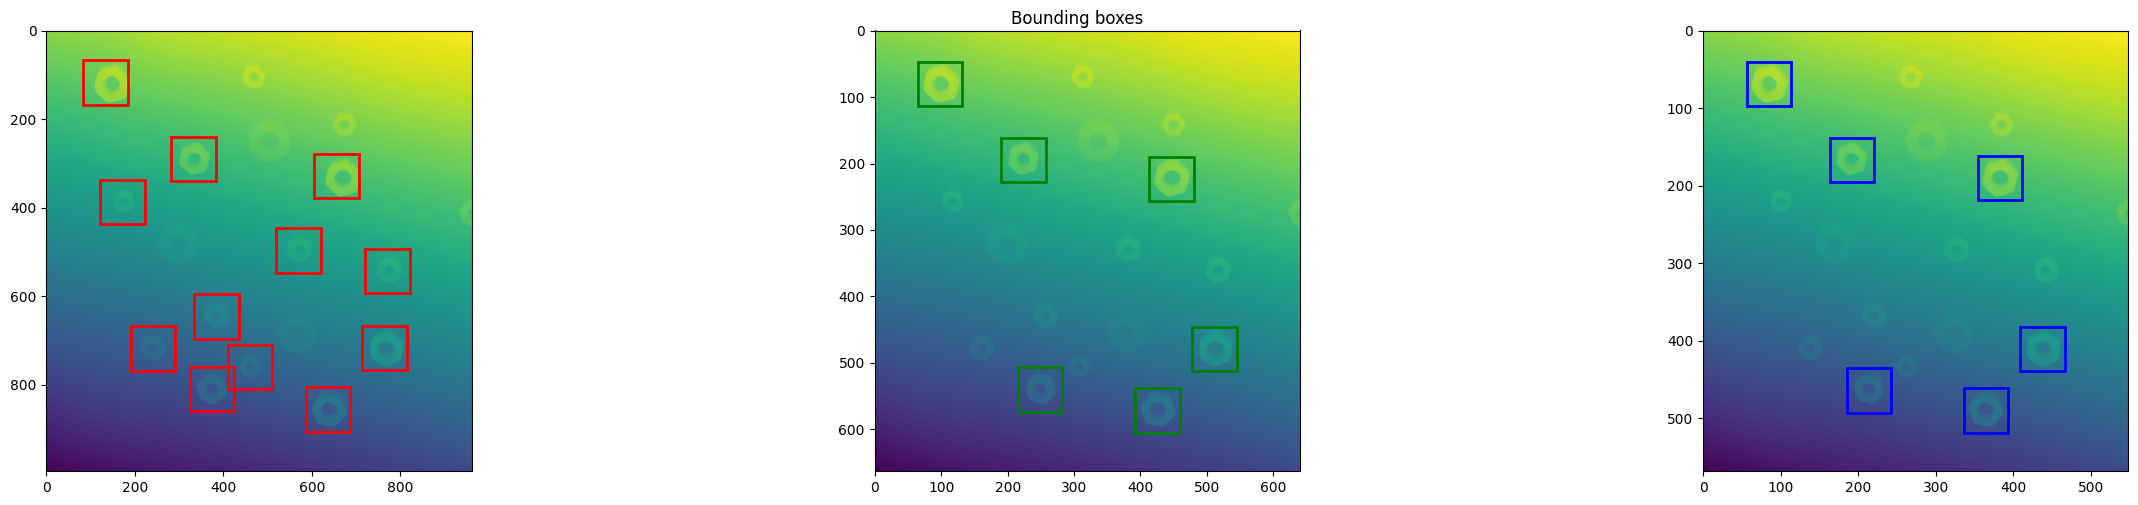

In [55]:
fig, axs = plt.subplots(1, len(scaled_images), figsize=(25, 5))
fig.tight_layout()
fig.suptitle('Bounding boxes', y=1)

colors = ['r', 'g', 'b']  # red, green, blue

for i, image in enumerate(scaled_images):
    axs[i].imshow(image)

    for bbox in all_bboxes[i]:
        rect = plt.Rectangle((bbox[1], bbox[0]), bbox[3] - bbox[1], bbox[2] - bbox[0],
                             linewidth=2, edgecolor=colors[i], facecolor='none')
        axs[i].add_patch(rect)

plt.show()

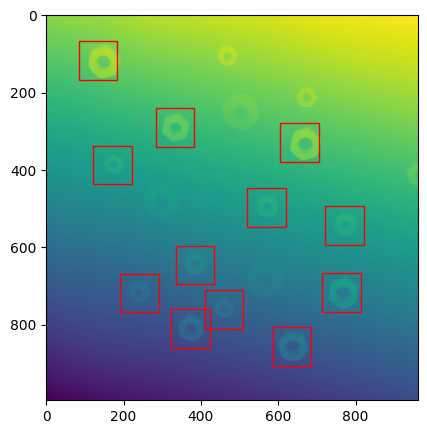

In [56]:
# Asegurémonos de que las bounding boxes están en la misma escala que la imagen original
all_bboxes_scaled = []
for i in range(len(scales)):
    bboxes_scaled = all_bboxes[i] * scales[i]  # Ajustamos las coordenadas de los bounding boxes
    all_bboxes_scaled.append(bboxes_scaled)

# Ahora concatenamos todos los bounding boxes en una sola lista
all_bboxes_concat = np.concatenate(all_bboxes_scaled)

# Aplicamos Non Maxima Suppression
confidences = [1] * len(all_bboxes_concat)
indices = cv2.dnn.NMSBoxes(all_bboxes_concat.tolist(), confidences, score_threshold=0, nms_threshold=0.5)

# Necesitamos convertir los índices a una lista plana
indices = [int(i) for i in indices]
final_bboxes = [all_bboxes_concat[i] for i in indices]

# Ploteamos los bounding boxes finales en la imagen original
fig, ax = plt.subplots(1, figsize=(8, 5))
ax.imshow(final_image)

for bbox in final_bboxes:
    rect = patches.Rectangle((bbox[1], bbox[0]), bbox[3]-bbox[1], bbox[2]-bbox[0], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

# Lista de parámetros cruciales a analizar
---
- Transformaciones 3D:
```python
# Definir los rangos de transformación
transformation_ranges = {'ax': [-5, 5], 'ay': [-5, 5], 'az': [-5, 5],
                         'tx': [-crop_size*0.05, crop_size*0.05], 'ty': [-crop_size*0.05, crop_size*0.05], 'tz': [0, 0]}
```

- Tamaño de las imágenes de entrenamiento (wide)
```python
wide = 20 # size of the training template
downsample = crop_size // wide
```

- Transformaciones a realiza(énfasis en la traslación y el ruido Gaussiano)
```python
transformations = (
    dt.Affine(translate=lambda:np.random.uniform(-1.5, 1.5, 2), rotate=lambda: np.random.rand()*np.pi*2),
    dt.AveragePooling(ksize=(downsample, downsample, 1)),
    dt.Add(lambda: np.random.randn() * 0.1),
    dt.Gaussian(sigma=lambda:np.random.uniform(0, 0.01)),
    dt.Multiply(lambda: np.random.uniform(0.6, 1.2))
)
```

- Escala de las imágenes:
```python
scales = [1, 1.5, 1.75]
x_shape = test_image.shape[0]
y_shape = test_image.shape[1]
scaled_images = [cv2.resize(test_image, (int(y_shape//scale), int(x_shape//scale))) for scale in scales]
```

- Parámetros de detección
```python
# Detection settings
cutoff = 0.9
alpha = 1 - cutoff
mode = "quantile"
```

